## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *
from sklearn.decomposition import PCA

## Datasets dimensionality

In [2]:
tasks = ['openArena', 'detour', 'doubleTmaze', 'cylinder', 'permanence']

In [3]:
ms = []
bs = []
variances = []
for task in tasks:
    print(task)
    
    dataset, _ = load_dataset('datasets/'+task, file_format='.npy', load_pose=False)
    dataset = dataset[:10000]
        
    n_imgs = dataset.shape[0]
    
    dataset_reduced = PCA().fit(dataset.reshape((n_imgs, int(84*84*3))))
    variances_dataset = dataset_reduced.explained_variance_ratio_
    cum_variances_dataset = np.cumsum(variances_dataset)
    
    cutoff_fit = 2000
    x = np.arange(1, n_imgs+1)
    y = variances_dataset
    m, b = np.polyfit(np.log(x[:cutoff_fit]), np.log(y[:cutoff_fit]), 1)
    
    ms.append(m)
    bs.append(b)
    variances.append(variances_dataset)

openArena
detour
doubleTmaze
cylinder
permanence


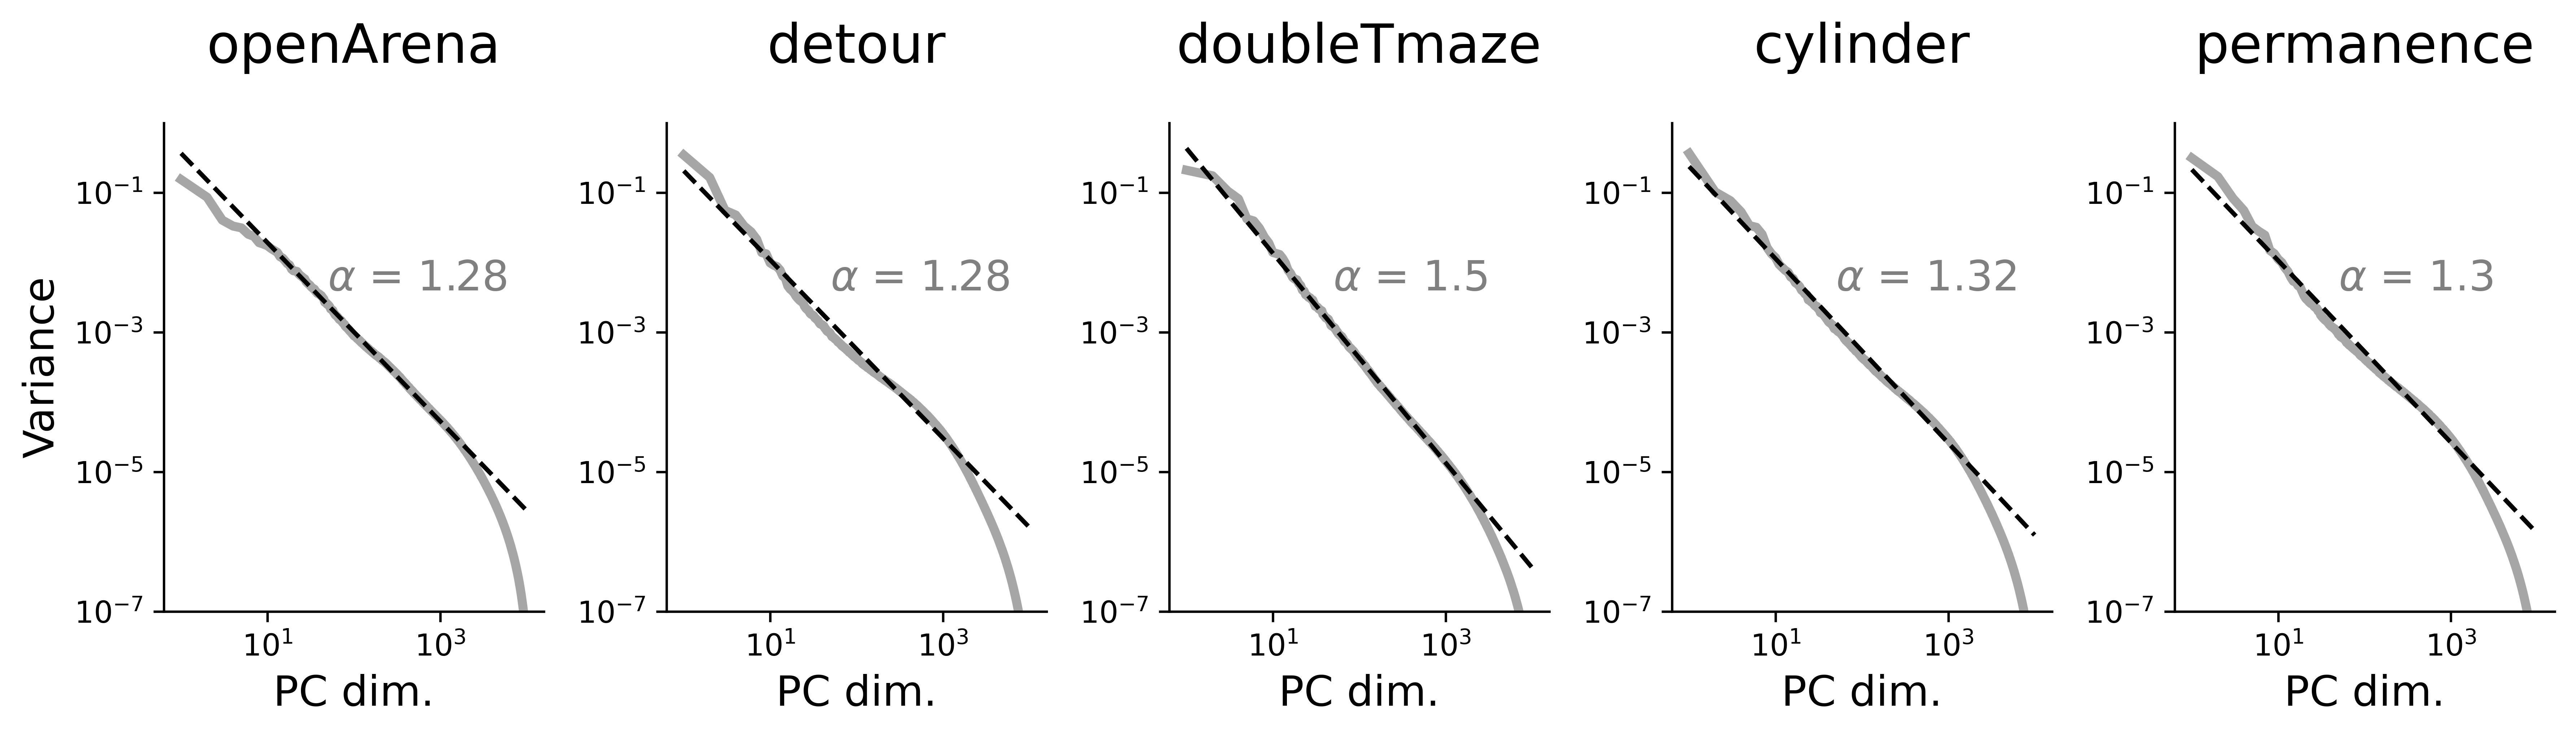

In [12]:
plt.figure(figsize=(12,3.5), dpi=600)

for i, task in enumerate(tasks):
    plt.subplot(1, len(tasks), i+1)

    plt.title(task, fontsize=18, pad=20)

    plt.plot(np.arange(1, len(variances[i])+1), variances[i], color='gray', linewidth=3, alpha=0.7)
    
    x_fit = np.linspace(1, len(variances[i])+1, 100)
    y_fit = np.exp(bs[i]) * x_fit**ms[i]
    plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)
    
    plt.text(x=50, y=4e-3, s='$\u03B1$ = '+str(np.around(-ms[i], 2)), color='gray', fontsize=14)
    if i==0: plt.ylabel('Variance', fontsize=14)
    plt.xlabel('PC dim.', fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1, 1e3)
    plt.ylim(1e-7, 1e-0)

    sb.despine()

plt.tight_layout()

plt.savefig('plots/powerlaw_environments.png', dpi=600)

plt.show()

## Autoencoder network

In [217]:
task = tasks[4]

In [225]:
model = Conv_AE(n_hidden=100).to('cuda')

In [226]:
model.load_state_dict(torch.load('saved_models/{}_sparse-AE_100hidden.pth'.format(task)))

<All keys matched successfully>

In [220]:
dataset, _ = load_dataset('datasets/'+task, file_format='.npy', load_pose=False)
train_loader = create_dataloader(dataset, batch_size=256, reshuffle_after_epoch=True)

In [155]:
history, _, _, _ = train_autoencoder(model, train_loader, dataset=[], num_epochs=1000, learning_rate=1e-5, alpha=0) 

Epoch 64/1000, Loss: 0.0057: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.82it/s]


Epoch 128/1000, Loss: 0.0035: 100%|████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 13.07it/s]


Epoch 166/1000, Loss: 0.0011:  38%|██████████████████████▌                                     | 15/40 [00:01<00:01, 12.80it/s]


KeyboardInterrupt: 

In [161]:
#torch.save(model.state_dict(), 'saved_models/detour_AE_100hidden.pth')

In [227]:
embeddings = get_latent_vectors(dataset, model)

In [228]:
model.eval()

criterion = nn.MSELoss()

# Disable gradient computation
with torch.no_grad():
    total_mse = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to('cuda')
        predictions = model(inputs)[0]
        mse = criterion(predictions, inputs)
        total_mse += mse.item() * inputs.size(0)  # Multiply by batch size

average_mse = total_mse / len(train_loader.dataset)

In [229]:
average_mse

0.0030755932252854107

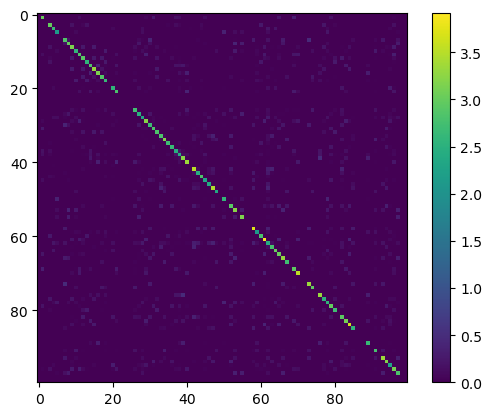

In [230]:
plt.imshow(np.dot(embeddings.T, embeddings))
plt.colorbar()
plt.show()

### Pairwise correlations

In [10]:
from scipy.stats import pearsonr

def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[1]
    correlations = []
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[:, i], data[:, j])
            correlations.append(corr)

    return correlations

In [11]:
correlations_ortho = compute_pairwise_correlations(embeddings_ortho)

In [12]:
correlations_nonortho = compute_pairwise_correlations(embeddings_nonortho)

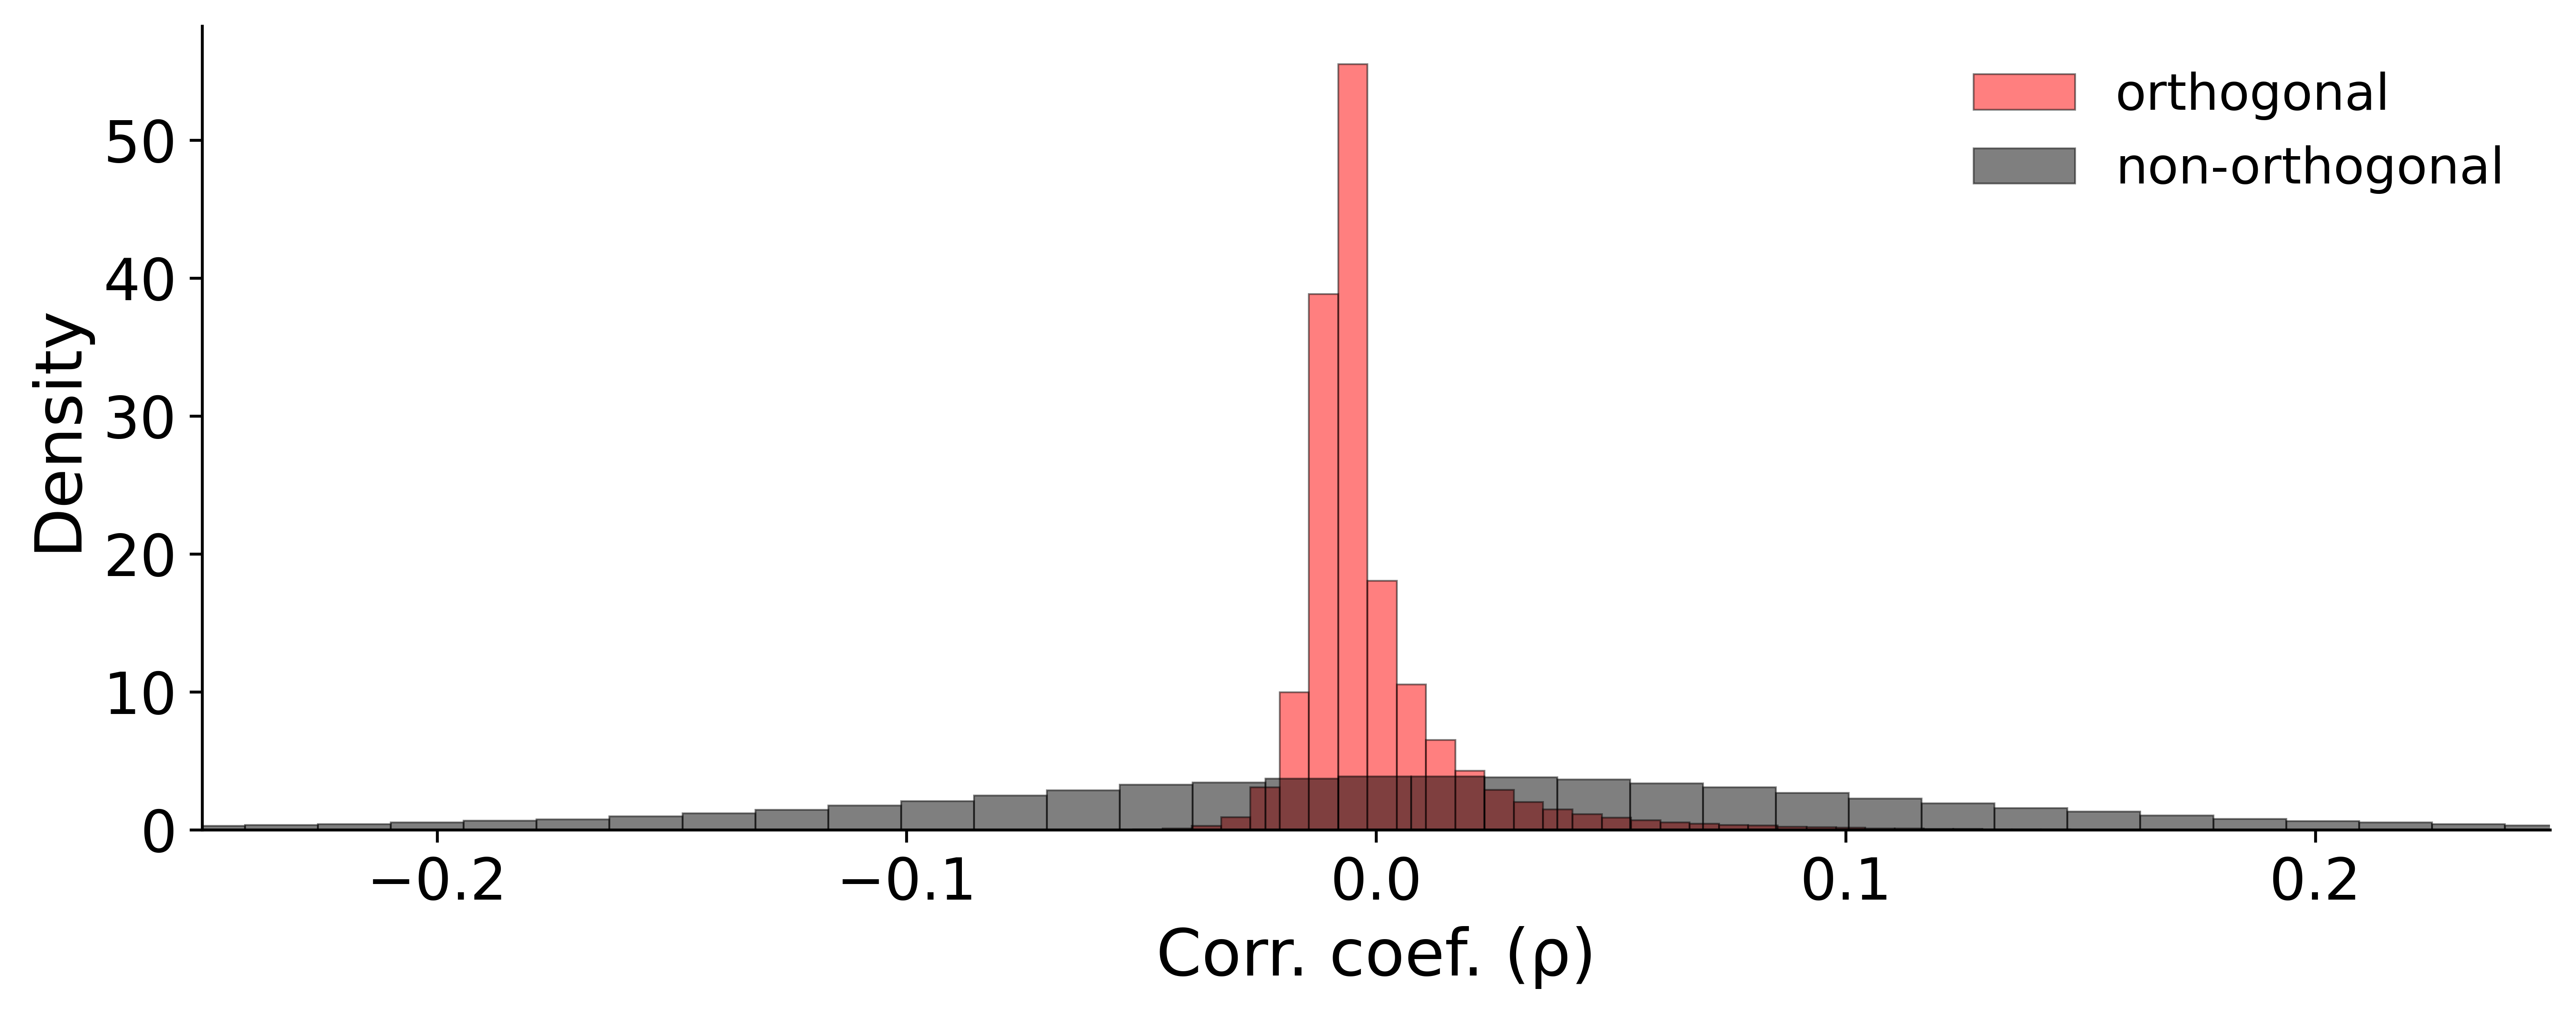

In [17]:
plt.figure(figsize=(10,4), dpi=600)

plt.hist(correlations_ortho, bins=100, color='r', alpha=.5, edgecolor='k', linewidth=.5, density=True, label='orthogonal')
plt.hist(correlations_nonortho, bins=100, color='k', alpha=.5, edgecolor='k', linewidth=.5, density=True, label='non-orthogonal')

#plt.axvline(x=np.nanmean(correlations_nonortho), color='k', linestyle='--')

plt.xlabel('Corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-0.25, 0.25)

plt.legend(frameon=False, fontsize=14)

sb.despine()
plt.tight_layout()
plt.savefig('plots/pairwiseCorrDistr_AE.png', dpi=600)
plt.show()

### Weight vector (kernel) similarity

In [19]:
W_ortho = model_ortho.fc1.weight.detach().cpu().numpy()
W_ortho_clean = W_ortho[np.any(embeddings_ortho, axis=0), :]
sim_W_ortho_clean = np.dot(W_ortho_clean, W_ortho_clean.T)*(1-np.eye(W_ortho_clean.shape[0]))
sim_vals_W_ortho = sim_W_ortho_clean.flatten()

In [21]:
W_nonortho = model_nonortho.fc1.weight.detach().cpu().numpy()
W_nonortho_clean = W_nonortho[np.any(embeddings_nonortho, axis=0), :]
sim_W_nonortho_clean = np.dot(W_nonortho_clean, W_nonortho_clean.T)*(1-np.eye(W_nonortho_clean.shape[0]))
sim_vals_W_nonortho = sim_W_nonortho_clean.flatten()

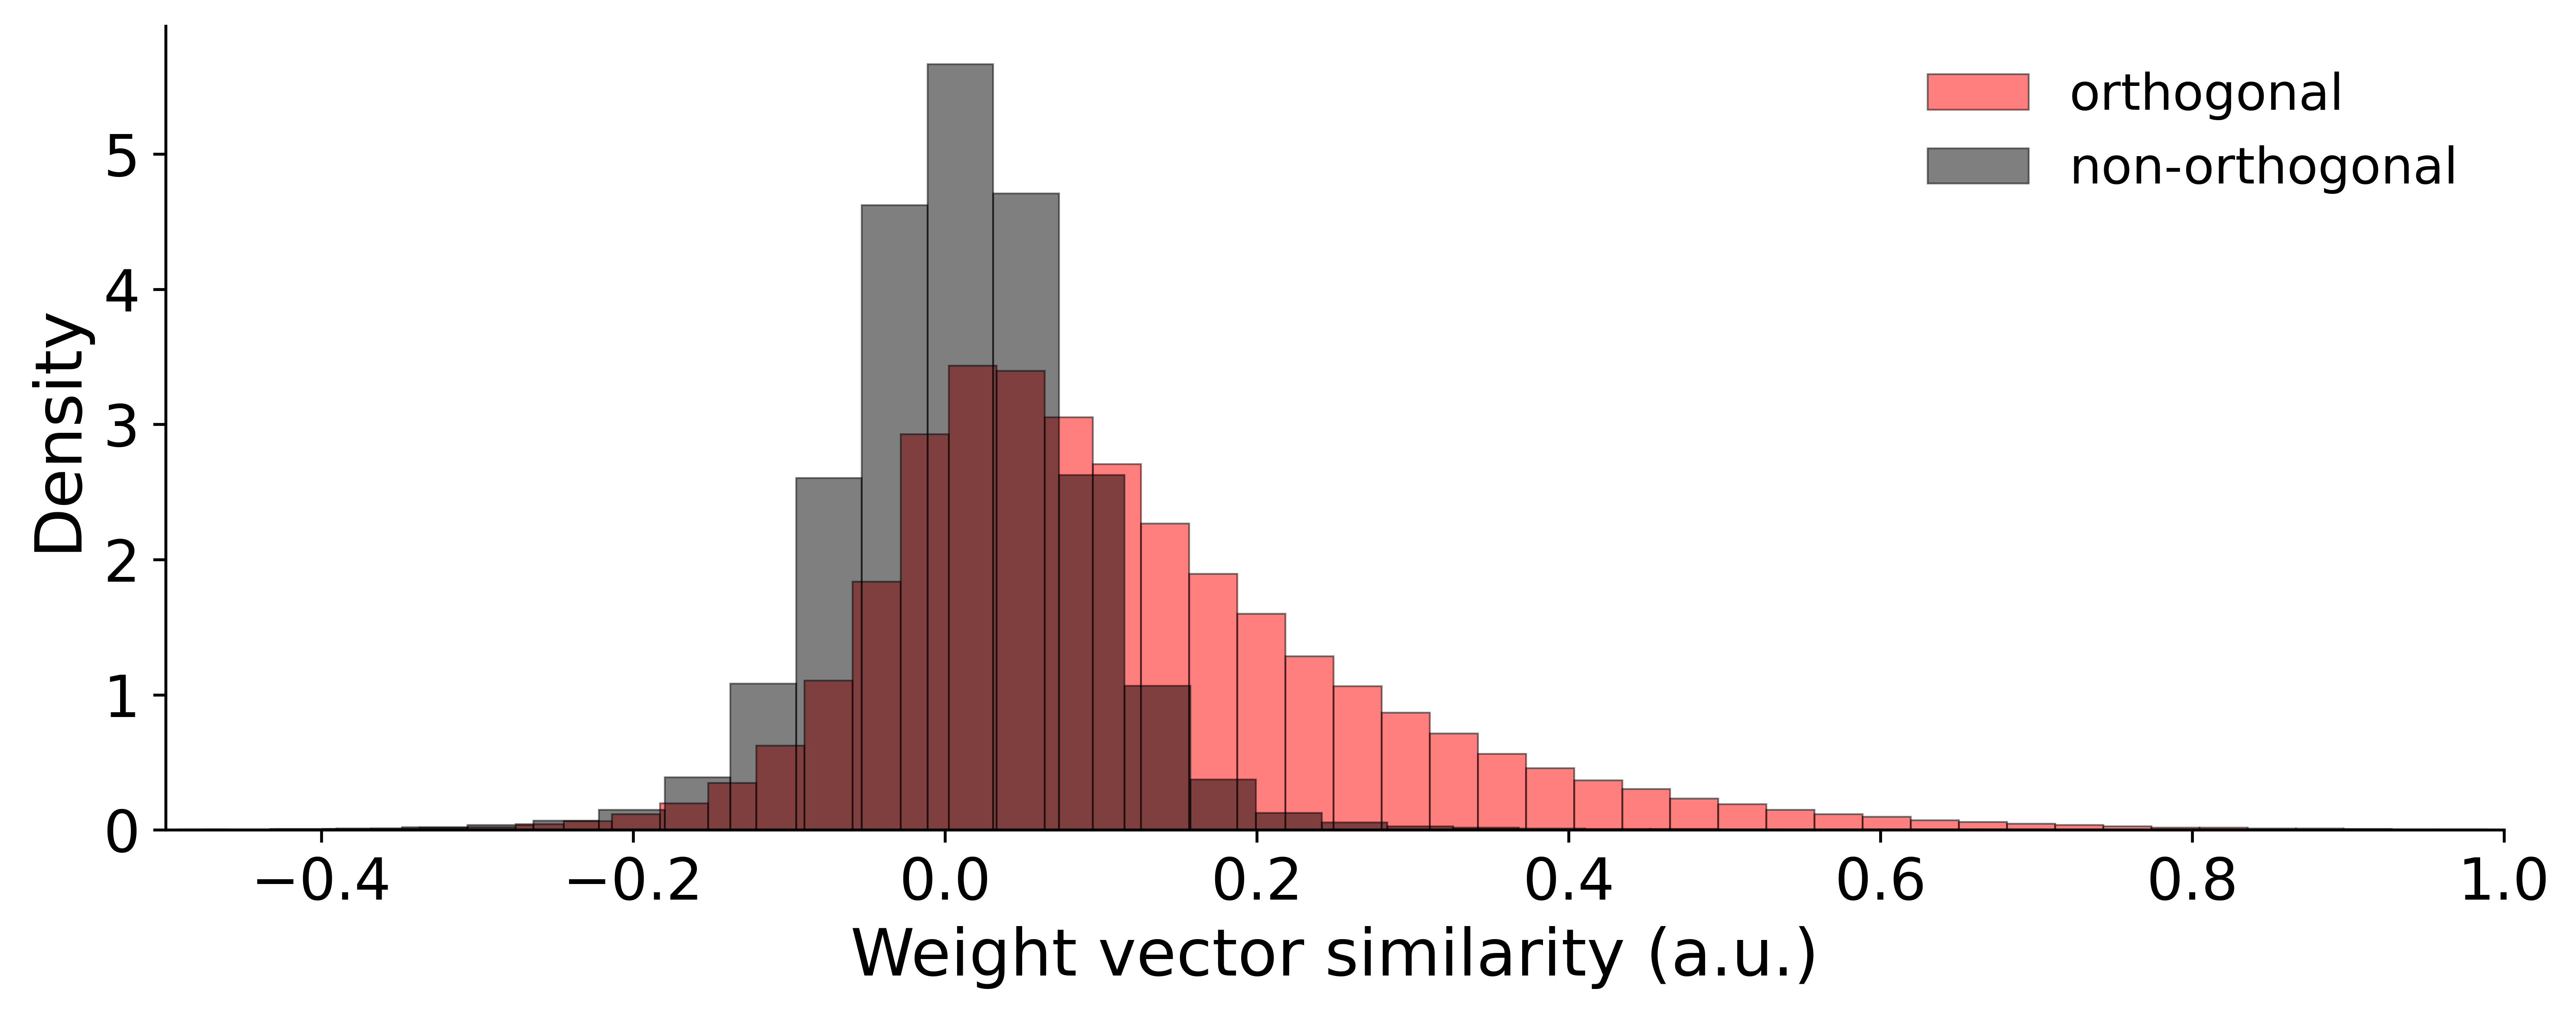

In [24]:
plt.figure(figsize=(10,4), dpi=600)

plt.hist(sim_vals_W_ortho, bins=100, color='r', alpha=.5, edgecolor='k', linewidth=.5, density=True, label='orthogonal')
plt.hist(sim_vals_W_nonortho, bins=100, color='k', alpha=.5, edgecolor='k', linewidth=.5, density=True, label='non-orthogonal')

#plt.axvline(x=np.nanmean(correlations_nonortho), color='k', linestyle='--')

plt.xlabel('Weight vector similarity (a.u.)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-0.5, 1)

plt.legend(frameon=False, fontsize=14)

sb.despine()
plt.tight_layout()
plt.savefig('plots/weightSimilarityDistr_AE.png', dpi=600)
plt.show()